In [2]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
import scipy.stats as st
import os
from sklearn.metrics import auc 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


def GetParams(parameters_df, ID, style = 'mode'):
    ''' 
    input:
        - data frame with parameter values as columns, individuals as rows
        - ID identifying individual of interest
        - style = 'mode' or 'mean' or 'SAEM' depending on which parameter values are preferred
    return:
        - dictionary with parameter names as key and parameter values as values
    '''
    i = ID
    cols = list(parameters_df)
    pid_params = parameters_df[parameters_df.id == i].copy()
    values = []
    keys = []
    for c in cols:
        if style in c:
            k = c.split('_')[0]
            keys.append(k)
            v = pid_params[c].values[0]
            values.append(v)
        for i,(v,k) in enumerate(zip(values, keys)):
            if 'log10' in k:
                values[i] = 10**v
                keys[i] = k.split('0')[1]

    params = dict(zip(keys, values))
    return params

def Simulate(func, param_order, param_dict, init, tend, N):
    '''
    input: 
        - func is a function that takes in the state variable, time and parameters and returns the derivative
        - params is a dictionary of the parameter values 
        - init is a dictionary of the initial condition to simulate from 
    return: 
        - trajectory simulated from init for tspan using func with given params
    '''
    # make parameter list in correct order
    params = []
    for k in param_order:
        params.append(param_dict[k])
    # extract initial time
    if 'tzero' in param_dict:
        t0 = -param_dict['tzero']
    else:
        t0 = 0 
    # build tspan
    tspan = np.linspace(t0,tend,N)
    # incorporate V0
    V0 = param_dict['V0']
    init[4] = V0
    # simulate using scipy integrate
    y = spi.odeint(func, init, tspan, args = tuple(params))
    return tspan,y

def Simulate2(func, param_order, param_dict, init, tend, N):
    '''
    input: 
        - func is a function that takes in the state variable, time and parameters and returns the derivative
        - params is a dictionary of the parameter values 
        - init is a dictionary of the initial condition to simulate from 
    return: 
        - trajectory simulated from init for tspan using func with given params
    '''
    # make parameter list in correct order
    params = []
    for k in param_order:
        params.append(param_dict[k])
    t0 = 0 
    # build tspan
    tspan = np.linspace(t0,tend,N)
    # simulate using scipy integrate
    y = spi.odeint(func, init, tspan, args = tuple(params))
    return tspan,y


# Put fixed paramters in a dictionary
fixed_params = dict({'c': 15, 'k':4})
T_0 = 10**7
R_0 = 0;
E_0 = 0;
I_0 = 0;
V_0 = 0;
init = [T_0, R_0, E_0, I_0, V_0]

# Write function for model simulation
def deriv(y, t, beta, phi, rho, k, delta,h, m, pi, c,tAI):
    T,R,E,I,V = y
    
    if t > tAI:
        eps = m
    else:
        eps = 0
        
    ddt_T = -beta*T*V - phi*I*T + rho*R
    ddt_R = phi*I*T -rho*R
    ddt_E = beta*T*V - k*E
    ddt_I = k*E - delta*np.maximum(I,.000001)**h*I - eps*I
    if I >=1:
        ddt_V = pi*I-c*V
    else:
        ddt_V = -c*V


    return ddt_T, ddt_R, ddt_E, ddt_I, ddt_V

param_order = ['beta', 'phi', 'rho', 'k', 'delta','h', 'm', 'pi', 'c', 'tAI']
colorDict = {0:'steelblue', 1:'seagreen',2:'goldenrod', 3:'firebrick', 4:'indigo'}

data_file = r'/Users/kowens2/Documents/SARS-CoV-2 Rebound/NBACohortMay2023/DataPreProcessing/NBA_6Clusters_810infections.xlsx'
parameters_file = r'/Users/kowens2/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Monolix/NBA Cohort/Projects/FitAllInfectionsAppendNegatives/T0_1x107_E0_0_I0_0_V0_est/IndividualParameters/estimatedIndividualParameters.txt'
#parameters_file = r'/Users/kowens2/Desktop/T0_8x107_V0_est/GetModes/T0_8x107_V0_est_001/IndividualParameters/estimatedIndividualParameters.txt'
# load parameters into data frame
parameters_df = pd.read_csv(parameters_file)
# load data into data frame
data_df = pd.read_excel(data_file)

# list unique infection IDs
IDs = list(parameters_df.id.unique())
# list infection IDs used in clustering
IDs_clustered = list(data_df.ID.unique())

clusters = []
for ID in IDs_clustered: 
    cluster = list(data_df[data_df['ID']==ID].Cluster)[0]
    clusters.append(cluster)
    


### Simulate model for infections used in clustering and extract kinetic features.



In [3]:
N = 100
X = np.zeros((len(IDs_clustered),N))

PkVLs = []
TimetoPeakVL = []
AUCs = []

for count, i in enumerate(IDs_clustered):
    ind_params = GetParams(parameters_df, i, style = 'mode')
    tzero = ind_params['tzero']
    params_dict = {**fixed_params, **ind_params}
    t0,y0 = Simulate(deriv, param_order, params_dict, init, 0 , N);
    t,y = Simulate2(deriv, param_order, params_dict, y0[-1,:], 20 , N);
    I = y[:,3]
    V = y[:,4]
    PkVLs.append(np.log10(max(V)))
    AUCs.append(auc(t,np.log10(np.maximum(V,250))))
    TimetoPeakVL.append(t[np.argmax(V)])
    
    X[count,:] = np.log10(np.maximum(V,300))

### Pre-process data and extract kinetic features

In [5]:
from scipy.interpolate import interp1d
mode = 'linear'

Xdata = np.arange(-14,50)
neg = 2.6576096821516124;

for id in IDs_clustered:
    df_id = data_df[data_df['ID'] ==id].copy()

    y_interp_1 = interp1d(df_id.time,df_id.y, kind = mode)
    xmin = np.min(df_id.time); 
    xmax = np.max(df_id.time);

    y_tested = y_interp_1(np.arange(xmin,xmax,1))
    y_tested = np.concatenate((neg*np.ones((xmin+14)),y_tested ))
    times = np.arange(-14,xmax)
    y_tested = np.concatenate((y_tested,neg*np.ones((50-xmax)), ))
    times = np.arange(-14,50)

    Xdata = np.vstack((Xdata,np.maximum(y_tested, neg)))

times = Xdata[0,:]
ppl = Xdata[1:,:]


Xdata = ppl[:,14:-30]
tdata = times[14:-30]

# -- quantitative features based on data 

# Add a column for the peak viral load
DataPeak = []
DataTimeToPeak = []
DataAUC = []

for i in np.arange(0,810):
    V = Xdata[i,:]
    DataPeak.append(max(V))
    DataAUC.append(auc(tdata,V))
    DataTimeToPeak.append(tdata[np.argmax(V)])

### Plot

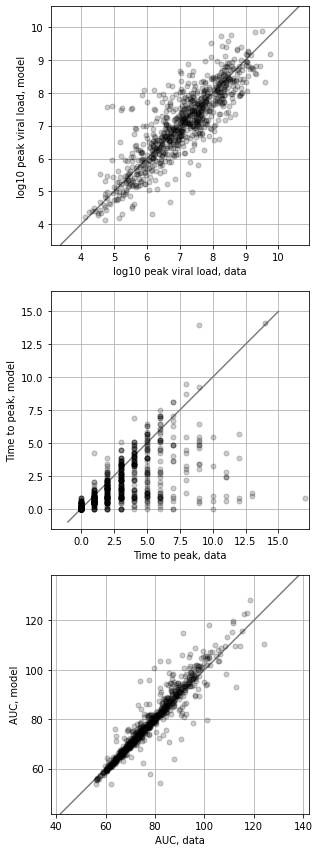

In [7]:
# -- Plots
fig, axs = plt.subplots(3,1, figsize = (4.5,12))
x = np.arange(3,12)
axs[0].plot(x,x, 'tab:gray')
axs[0].plot(DataPeak,PkVLs,'k.', markersize = 10, alpha = .2)
axs[0].set_xlabel('log10 peak viral load, data' )
axs[0].set_ylabel('log10 peak viral load, model')
axs[0].axis('equal')
axs[0].set_ylim(4,10)
axs[0].set_xlim(4,10)
axs[0].grid()

x = np.arange(-1,16)
axs[1].plot(x,x, 'tab:gray')
axs[1].plot(DataTimeToPeak,TimetoPeakVL,'k.', markersize = 10, alpha = .2)
axs[1].set_xlabel('Time to peak, data' )
axs[1].set_ylabel('Time to peak, model' )
#axs[1].set_ylabel('Time to peak, model simulation')
axs[1].axis('equal')
axs[1].set_ylim(0,15)
axs[1].set_xlim(0,15)
axs[1].grid()

x = np.arange(30,140)
axs[2].plot(x,x, 'tab:gray')
axs[2].plot(DataAUC,AUCs,'k.',markersize = 10, alpha = .2)
axs[2].set_xlabel('AUC, data' )
axs[2].set_ylabel('AUC, model' )
#axs[2].set_ylabel('AUC, model simulation')
axs[2].axis('equal')
axs[2].set_ylim(50,130)
axs[2].set_xlim(50,130)
axs[2].grid()
    
plt.tight_layout()

### Try clustering daily samples from model trajectories

[151, 184, 150, 162, 85, 78]


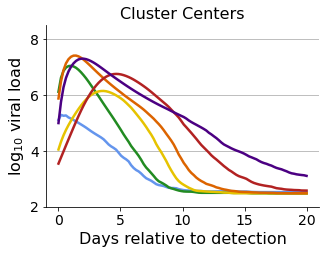

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state = 10).fit(X)
centers = [auc(t,y) for y in kmeans.cluster_centers_]
sort_index = np.argsort(centers)

plt.rcParams.update({'font.size': 14})
fig, axs = plt.subplots(figsize = (4.75,3.75), frameon = False)

colors = ['cornflowerblue','forestgreen', [230/255,195/255,0],[220/255,100/255,0], 'firebrick', 'indigo']
Dict = dict([(x,c) for x,c in zip(sort_index, colors)])
for count in sort_index:
    cc = kmeans.cluster_centers_[count]
    plt.plot(t,cc, color = Dict[count], linewidth = 2.5)

plt.ylim(2,8.5)
plt.grid(axis = 'y')    
plt.xlabel('Days relative to detection', fontsize=16)
plt.ylabel('log$_{10}$ viral load', fontsize=16)
plt.title('Cluster Centers', fontsize=16)
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)

print([np.sum(kmeans.labels_== c) for c in sort_index])
plt.tight_layout()

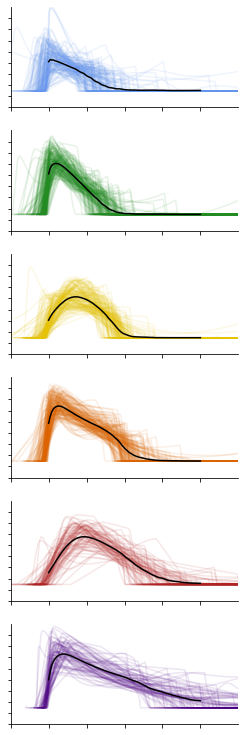

In [11]:
# -- clustering based on model simulations -- simulate from t0 to t = 25 days
fig, axs = plt.subplots(6,1, figsize = (3.75, 10.55))
plt.rcParams.update({'font.size': 18})

for count, i in enumerate(IDs_clustered): 
    ind_params = GetParams(parameters_df, i, style = 'mode')
    tzero = ind_params['tzero']
    params_dict = {**fixed_params, **ind_params}
    t,y = Simulate(deriv, param_order, params_dict, init, 25 , 250);
    V = np.log10(np.maximum(y[:,4],300))
    # identify data
    temp = data_df[data_df['ID'] == i].y
    cluster = kmeans.labels_[count]
    ydata = [float(y) for y in temp]
    p = np.where(sort_index == cluster)[0][0]
    axs[p].plot(t, V, color = Dict[cluster], alpha = 0.1)

center_inds = []
for count,cc in enumerate(kmeans.cluster_centers_):
    idx = np.argmin(np.sqrt(np.sum(np.abs(X-cc)**2, axis = 1)))
    label = kmeans.labels_[idx]
    p = np.where(sort_index == label)[0][0]
    axs[p].plot(np.linspace(0,20,100),cc, color = 'k')
    axs[p].set_ylim(2,10)
    axs[p].set_xlim(-5,25)
    center_inds.append(idx)
    axs[p].set_yticks(np.arange(1,10))
    axs[p].set_xticks(np.arange(-5,25,5))
    axs[p].set_xticklabels([])
    axs[p].set_yticklabels([])
    axs[p].spines['top'].set_visible(False)
    axs[p].spines['right'].set_visible(False)
    
plt.tight_layout()

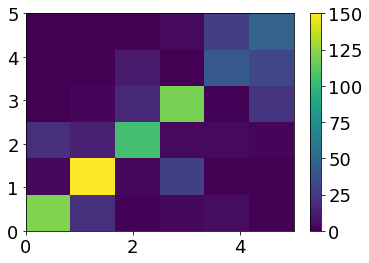

In [12]:
# -- compare results of clustering based on model simulations against clustering based on data
def reorder(l, sort_index):
    new_label = np.argwhere(sort_index==l)[0][0]
    return new_label

ordered_kmeans_labels = [reorder(l, sort_index) for l in kmeans.labels_]
plt.hist2d(clusters, ordered_kmeans_labels,bins = 6);
plt.colorbar()

In [35]:
# -- Accuracy
(810-np.sum((np.abs(np.array(clusters) - np.array(ordered_kmeans_labels))>0)))/810

0.7209876543209877

In [34]:
# -- How often are 4 and 5 mixed up?
Cdata = np.array(clusters)
Cmodels = np.array(ordered_kmeans_labels)

print('4 --> 4:', np.sum((Cmodels[np.argwhere(Cdata == 4)]==4))/np.sum(Cdata==4))
print('4 --> 5:', np.sum((Cmodels[np.argwhere(Cdata == 4)]==5))/np.sum(Cdata==4))
print('5 --> 5:', np.sum((Cmodels[np.argwhere(Cdata == 5)]==5))/np.sum(Cdata==5))
print('5 --> 4:', np.sum((Cmodels[np.argwhere(Cdata == 5)]==4))/np.sum(Cdata==5))

4 --> 4: 0.5316455696202531
4 --> 5: 0.34177215189873417
5 --> 5: 0.4519230769230769
5 --> 4: 0.3076923076923077
